In [1]:
import datetime

import netCDF4
import pandas as pd
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import seaborn as sns
import warnings
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
from tabulate import tabulate
plt.style.use('mpl15')
import cftime
import cartopy.crs as ccrs

xr.set_options(display_style="html")

In [2]:
%%time
# Here, we use the ERA5 data and the Python API interface to cdsapi.
#
# https://www.ecmwf.int/sites/default/files/elibrary/2015/18490-radiation-quantities-ecmwf-model-and-mars.pdf
# ERA5, Monthly Means of Daily Forecast Accumulations
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form
def get_era5(station, step):
    c = cdsapi.Client()
    station_name="{}_era_interim.nc".format(station["name"])
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
        'variable': [
           'land_sea_mask',
            'mean_surface_direct_short_wave_radiation_flux',
            'mean_surface_downward_short_wave_radiation_flux',
            'mean_surface_downward_short_wave_radiation_flux_clear_sky',
            'mean_surface_downward_uv_radiation_flux', 'sea_ice_cover',
            'total_cloud_cover',
        ],
        'year': '2012',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            90, -180, 50,
            180,
        ],
        'format': 'netcdf',
        },
        station_name)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [3]:
%%time
stations=[{"name":"Chukchi_sea",
           "lat":69.25,
           "lon":-171}]

for i, station in enumerate(stations):
    step=3
   # get_era5(station, step)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


     ECO_CODE                    ECOREGION  PROV_CODE  \
0     20192.0                 Agulhas Bank       51.0   
1     20053.0             Aleutian Islands       10.0   
2     20072.0                     Amazonia       13.0   
3     20194.0            Amsterdam-St Paul       52.0   
4     20228.0  Amundsen/Bellingshausen Sea       61.0   
..        ...                          ...        ...   
227   25034.0                   Ionian Sea        4.0   
228   25031.0                   Aegean Sea        4.0   
229   25036.0                  Alboran Sea        4.0   
230   25035.0        Western Mediterranean        4.0   
231   25010.0      High Arctic Archipelago        1.0   

                             PROVINCE  RLM_CODE                        REALM  \
0                             Agulhas      10.0    Temperate Southern Africa   
1    Cold Temperate Northeast Pacific       3.0   Temperate Northern Pacific   
2                  North Brazil Shelf       4.0            Tropical Atlanti

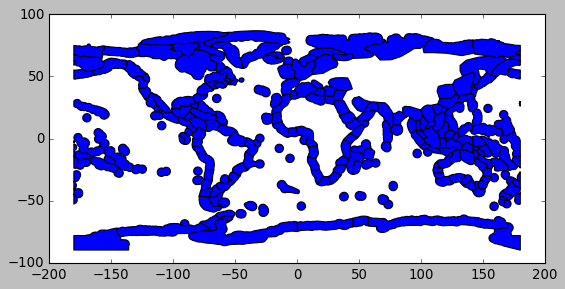

In [4]:
%%time
meow = gp.read_file("MEOW-TNC/meow_ecos.shp")
meow.plot()

print(meow)

<xarray.Dataset>
Dimensions:     (latitude: 161, longitude: 1440, time: 12)
Coordinates:
  * longitude   (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude    (latitude) float32 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
  * time        (time) datetime64[ns] 2012-01-01 2012-02-01 ... 2012-12-01
Data variables:
    lsm         (time, latitude, longitude) float32 ...
    msdrswrf    (time, latitude, longitude) float32 ...
    msdwswrf    (time, latitude, longitude) float32 ...
    msdwswrfcs  (time, latitude, longitude) float32 ...
    msdwuvrf    (time, latitude, longitude) float32 ...
    siconc      (time, latitude, longitude) float32 ...
    tcc         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-19 17:31:47 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
Par values range: 0.0 - 297.85443115234375 mean: 92.40570831298828
                 lsm    msdrswrf    msdwswrf  msdwswrfcs   msdwuvrf    siconc  \
time  

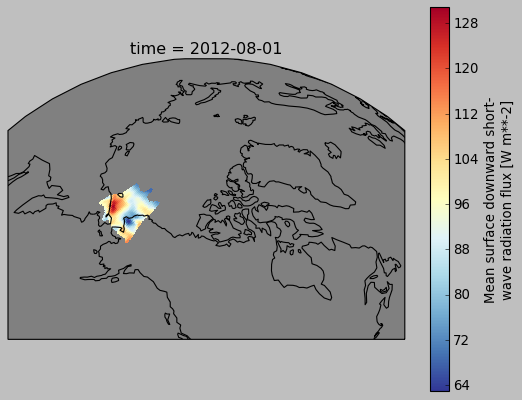

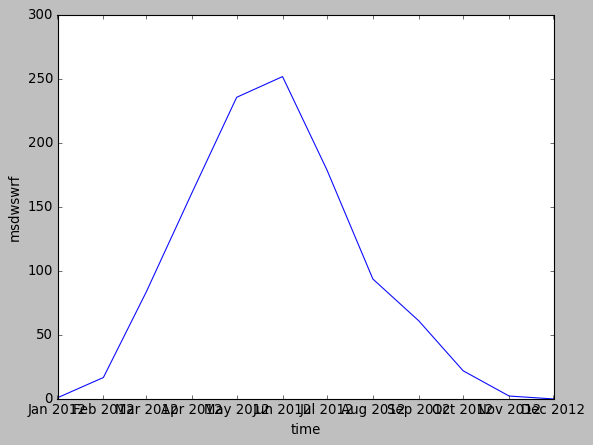

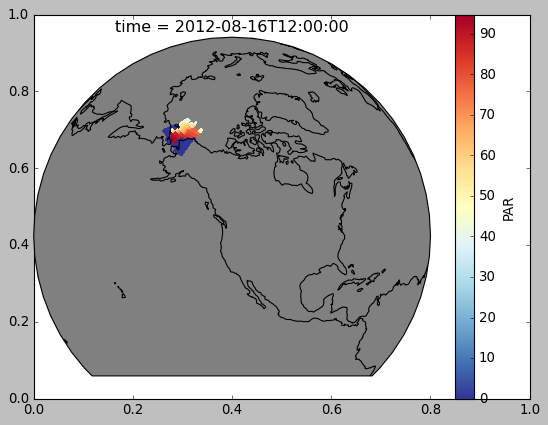

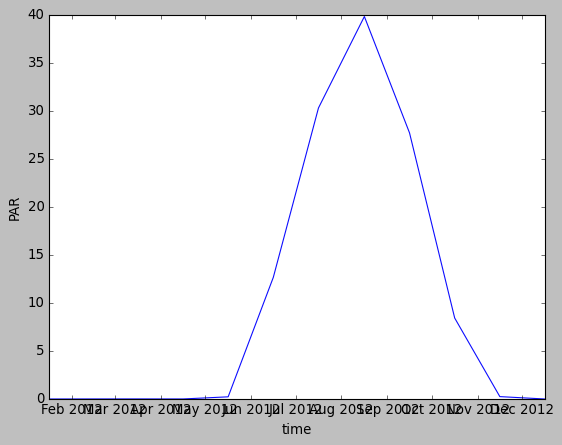

In [5]:
%%time
scenarios=["ssp585"]
ensemble_id="r1i1p1f1"
period="1950-01-01-2099-12-16"
models=["MPI-ESM1-2-LR"]
var_name="msdwswrf"

# Data extracted:
# https://apps.ecmwf.int/datasets/data/interim-mdfa/levtype=sfc/?month_years=2012&step=0-12&param=57.128,58.128,169.128

# Converting units see here:
# https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Monthlymeans
units_to_wm2 =1 #./(86400)

era = netCDF4.Dataset("{}_era_interim.nc".format(station["name"]))
units = 'hours since 1900-01-01 00:00:00.0'
time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')

times=[]
for t in time_gregorian:
    obj = datetime.datetime(year=t.year, month=t.month, day=t.day, hour=t.hour)
    times.append(obj)
times = pd.to_datetime(times,dayfirst=False)

for i, station in enumerate(stations):

    era = xr.open_dataset("{}_era_interim.nc".format(station["name"]),
                        #  decode_cf=True,
                          mask_and_scale=True)
                         # decode_times=False)
                         # use_cftime=True)

    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    print(era)
    era = era.rename({"latitude":"lat", "longitude":"lon"})

    mask = regionmask.mask_geopandas(meow[(meow.PROV_CODE==1) &
                                          (meow.ECOREGION=="Chukchi Sea")],
                                     era.lon, era.lat)

    par = era.where( mask < 2000) #.to_dataframe()

    p=par[var_name].isel(time=7).plot(cmap=mpl.cm.RdYlBu_r,
                                      subplot_kws=dict(projection=ccrs.Orthographic(-120, 45),
                                                     facecolor="gray"),
                                                     transform=ccrs.PlateCarree())

    p.axes.coastlines()
    print("Par values range: {} - {} mean: {}".format(np.nanmin(par[var_name]),
                                                      np.nanmax(par[var_name]),
                                                      np.nanmean(par[var_name])))
    par=par.to_dataframe().groupby("time").mean()
    print(par.head(12))
    fig, axes = plt.subplots(1, 1)
    sns.lineplot(ax=axes, data=par, x="time", y=var_name, ci=95, alpha=0.95)

    for scenario in scenarios:
        for model in models:
            fname="test_datasets/Light_{}_{}_{}_scenario_osa_{}.nc".format(model, ensemble_id,period,scenario)
            ds = xr.open_dataset(fname).sel(time=slice("2012-01-01","2012-12-31"))["PAR"][::3,:,:]

            lon = np.arange(0.5, 360)

            mask_ds = regionmask.mask_geopandas(meow[(meow.PROV_CODE==1) &
                                                  (meow.ECOREGION=="Chukchi Sea")],
                                             lon, ds.lat)


            df = ds.where( mask_ds < 2000).to_dataframe().groupby("time").mean()
            print(ds)
            fig, axes = plt.subplots(1, 1)
            p=ds.where( mask_ds < 2000).isel(time=7).plot(cmap=mpl.cm.RdYlBu_r,
                                      subplot_kws=dict(projection=ccrs.Orthographic(-120, 45),
                                                     facecolor="gray"),
                                                     transform=ccrs.PlateCarree())

            p.axes.coastlines()

            print(df.head(12))
            fig, axes = plt.subplots(1, 1)
            sns.lineplot(ax=axes, data=df, x="time", y="PAR", ci=95, alpha=0.95)
